In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score,\
        recall_score, classification_report, precision_recall_curve,\
        confusion_matrix, auc, roc_curve

In [3]:
from lightgbm import LGBMClassifier
import lightgbm
import  catboost as catb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [4]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#from sklearn.impute import KNNImputer

In [6]:
#from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
#from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler
#from sklearn.compose import ColumnTransformer
#import category_encoders as ce

In [7]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [8]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [9]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [10]:
def balance_df_by_target_advance(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [11]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [12]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2 # подсчитываем память потребляемую изначальным датасетом
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns: # проходимся по всем колонкам
        col_type = df[col].dtype  # узнаем тип колонки
        
        if col_type != object:
            c_min = df[col].min() # смотрим минимальное значение признака
            c_max = df[col].max() # смотрим максимальное значение признака
            if str(col_type)[:3] == 'int':  # if int
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: # сравниваем с int8
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: # сравниваем с int16 и.т.д.
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else: # если был тип object, то меняем его тип на пандасовский тип 'category', на нем разные агрегации данных работают в разы быстрее
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # считаем сколько теперь у нас занято памяти
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))  # и выводим статистику
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [13]:
def choise_features(data, model):
    X = data.drop(columns=['target'])
    y = data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        shuffle=True,
                                                        test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
    
    

    #lgb = LGBMClassifier(objective='binary',
     ##                   #n_estimators=50, 
    #                     #max_depth=3, 
    #                     metric = "f1",
    #                     #categorical_feature=cat_feats
    #                    )

    
    model.fit(X_train, y_train)


    evaluate_preds(model, X_train, X_test, y_train, y_test)

    feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                       columns=['feature_name', 'importance'])

    feature_importances.sort_values(by='importance', ascending=False)

    return X_train, X_test, y_train, y_test, feature_importances

In [14]:
def train_evaluate_preds(model, X_train, X_test, y_train, y_test):
    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
    
    

    #model_RF = RandomForestClassifier(random_state=21)

    
    model.fit(X_train, y_train)


    evaluate_preds(model, X_train, X_test, y_train, y_test)

    feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                       columns=['feature_name', 'importance'])

    feature_importances.sort_values(by='importance', ascending=False)

    return feature_importances

In [15]:
def target_encoder(X_train, y_train, X_test, encoded):
    Form = pd.concat([X_train[encoded], y_train], axis=1)
    Mask = pd.DataFrame(Form.groupby(by=encoded)['target'].mean()).\
           rename(columns={"target": f"{encoded}_mean"})
    X_train = pd.merge(X_train, Mask, how='left', on=encoded)
    X_test = pd.merge(X_test, Mask, how='left', on=encoded)
    
    return X_train, X_test

In [16]:
def log_columns(df, big_nunique_features):
    for col in big_nunique_features:
        const = np.min(df[col])
        if const > 0:
            const = 0
        else:
            const -= 0.1
        df[col] = np.log(df[col]-const+0.001)

In [17]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [18]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

kfold_cv = KFold(n_splits=3, shuffle=True, random_state=21)

def run_cv(estimator, cv, X, y, scoring='f1_macro',  model_name=""):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

In [23]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')

In [24]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 1039.31 MB
Memory usage after optimization is: 502.05 MB
Decreased by 51.7%
Memory usage of dataframe is 692.88 MB
Memory usage after optimization is: 342.31 MB
Decreased by 50.6%


In [25]:
train_df4 = train_df[train_df['vas_id']==4]
test_df4 = test_df[test_df['vas_id']==4]

In [26]:
train_df4.target.value_counts(normalize=True)

0.0    0.746191
1.0    0.253809
Name: target, dtype: float64

In [27]:
test_df4.target.value_counts(normalize=True)

0.0    0.746209
1.0    0.253791
Name: target, dtype: float64

In [28]:
train_df4.head(10)

,id,vas_id,buy_time_x,0,1,2,3,4,5,6,...,vas_id_08,vas_id_09,month,day,weekofyear,time_max,novelty,vas_id_day,is_action,target
6,264648,4.0,1531688400,-96.799973,-408.179108,-110.740784,-456.546783,-116.158249,-477.651794,-16.086180,...,0,0,7,197,29,1546203600,14515200,0,0,1.0
8,2354026,4.0,1545598800,724.050049,1110.620850,710.109192,1100.393188,704.691772,1079.288208,-16.086180,...,0,0,12,358,52,1546203600,604800,7,0,1.0
23,2620768,4.0,1543179600,-59.299973,99.490891,0.929214,259.353210,-4.488246,238.248215,-16.086180,...,0,0,11,330,48,1546203600,3024000,0,1,0.0
41,3174695,4.0,1532898000,-37.289970,-95.769112,-51.230785,-147.106796,-56.648247,-168.211792,-16.086180,...,0,0,7,211,31,1546203600,13305600,0,0,0.0
64,2260577,4.0,1531688400,120.580032,1300.370850,145.399216,1402.773193,139.981750,1544.348267,115.263817,...,0,0,7,197,29,1546203600,14515200,0,0,1.0
74,1097045,4.0,1540155600,-93.749969,-187.159119,-107.690788,-239.766800,-113.108246,-260.871796,-16.086180,...,0,0,10,295,43,1546203600,6048000,0,0,1.0
77,3359258,4.0,1542574800,159.980026,116.390884,294.339203,214.203201,288.921753,193.098206,-16.086180,...,0,0,11,323,47,1546203600,3628800,0,1,1.0
90,2125587,4.0,1531688400,-96.799973,-196.319107,-110.740784,-248.926804,-116.158249,-270.031799,-16.086180,...,0,0,7,197,29,1546203600,14515200,0,0,0.0
94,3771371,4.0,1534107600,-96.799973,-256.659119,-110.740784,-307.576813,-116.158249,-328.681793,-16.086180,...,0,0,8,225,33,1546203600,12096000,0,0,0.0
98,12084,4.0,1537736400,147.260025,-153.529114,138.399216,-199.366791,141.451752,-135.751785,-16.086180,...,0,0,9,267,39,1546203600,8467200,0,0,0.0


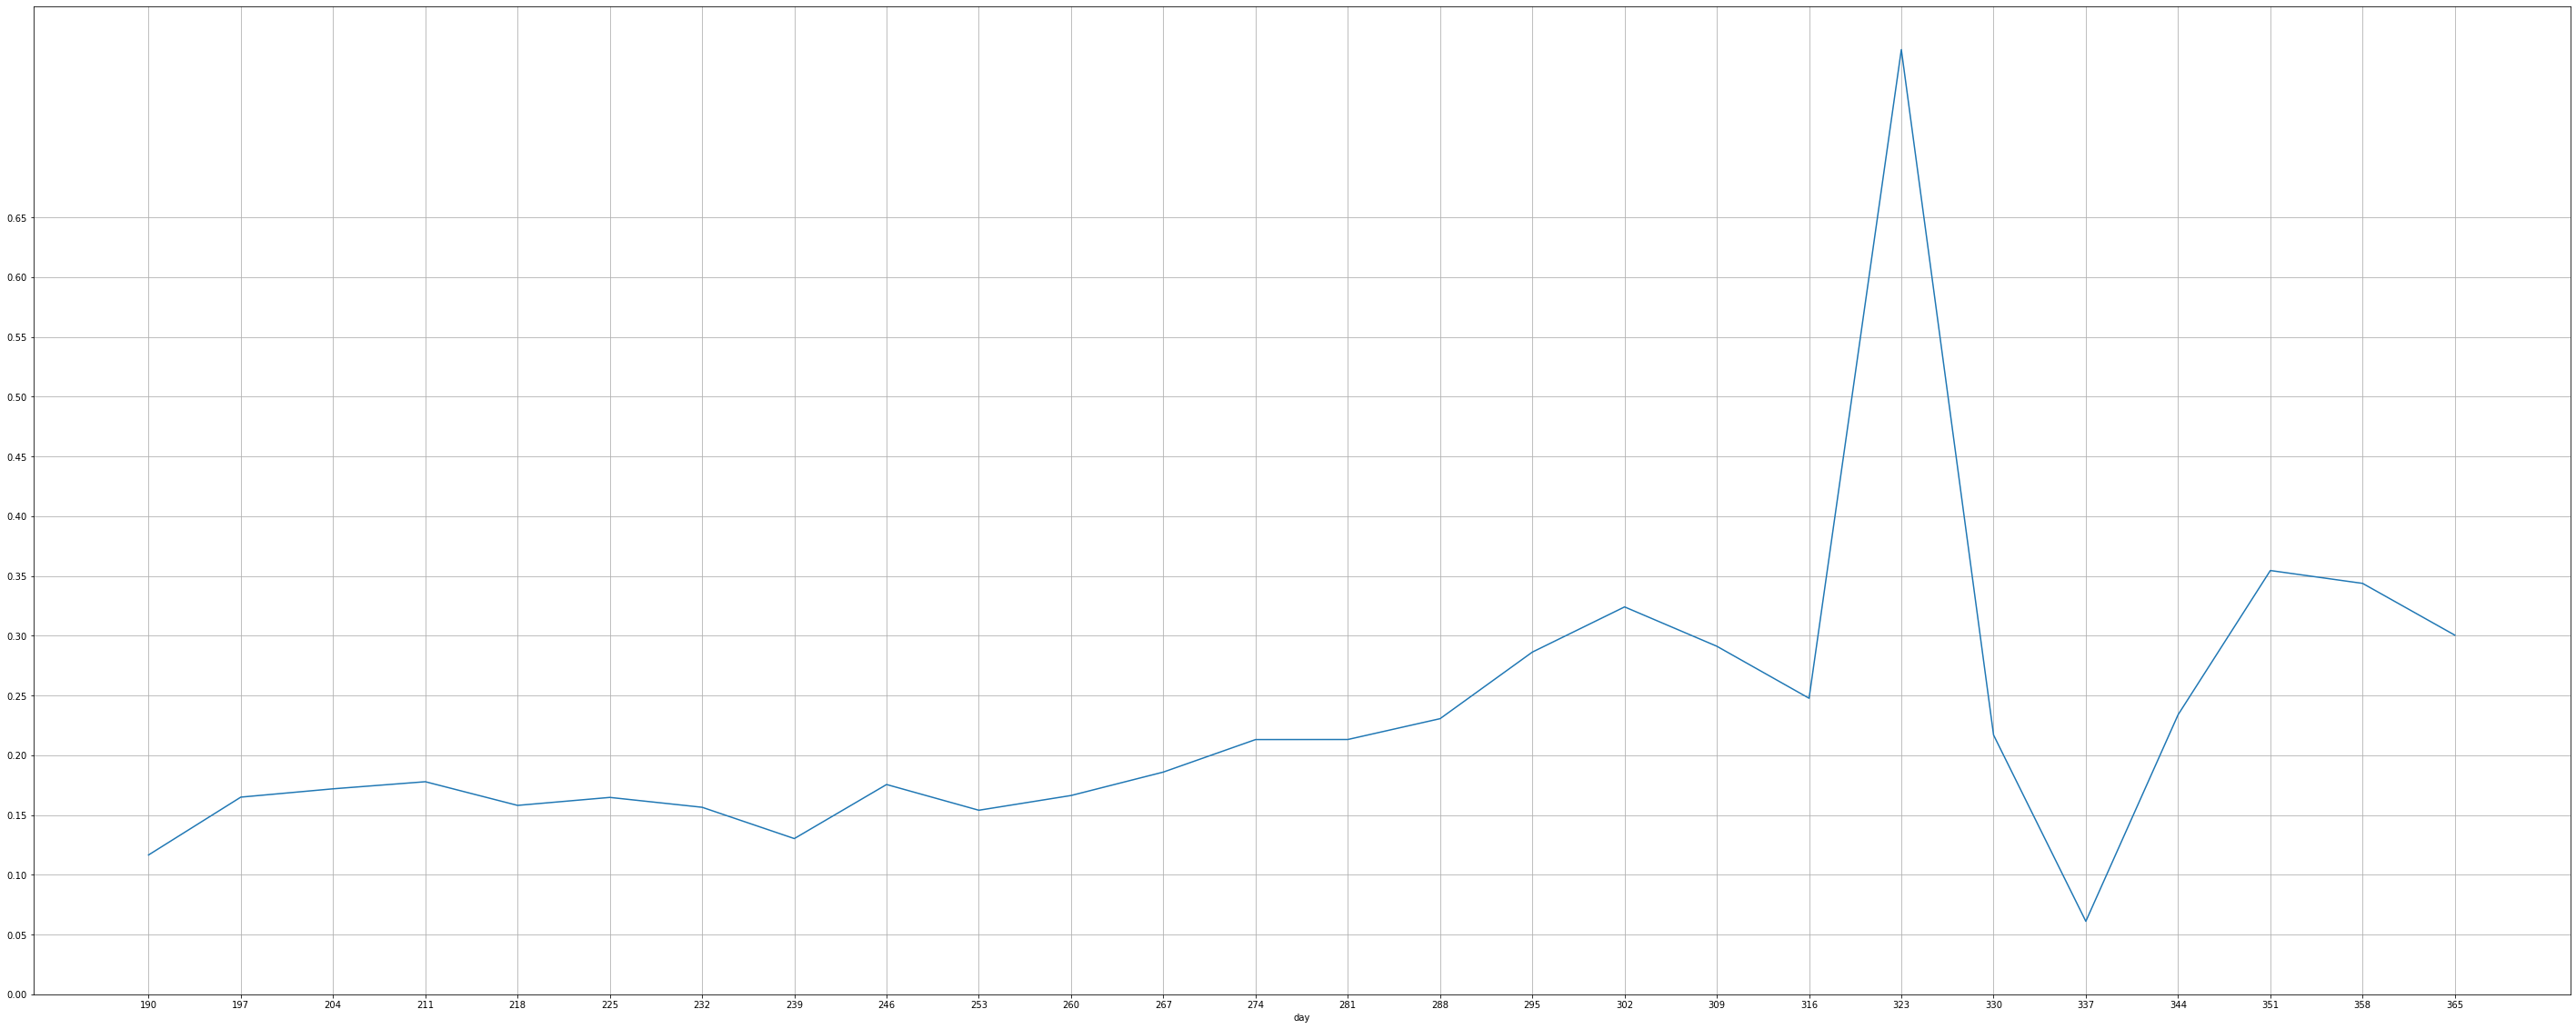

In [29]:
plt.figure(figsize=(50, 20))
train_df4.groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
plt.xticks(train_df4['day'].unique())
plt.yticks(np.arange(0, 0.7, 0.05))
plt.grid()
plt.show()

Выброс с 317 по 344 день.

# Разбиение на  train  и  test

In [30]:
TARGET_NAME = 'target'

In [31]:
X_train = train_df4.drop(columns=[TARGET_NAME])
y_train = train_df4[TARGET_NAME]
X_test = test_df4.drop(columns=[TARGET_NAME])
y_test = test_df4[TARGET_NAME]

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0.0    0.746191
1.0    0.253809
Name: target, dtype: float64

0.0    0.746209
1.0    0.253791
Name: target, dtype: float64

In [32]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0.0    38449
1.0    26156
Name: target, dtype: int64

In [33]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

# Поиск категориальных признаков среди вещественных

In [34]:
df_numerical = X_train.select_dtypes(include = [np.number])
df_categorical = X_train.select_dtypes(exclude = [np.number])

In [35]:
# Ищу признаки категориальные среди вещественных
select_spy = pd.DataFrame(df_numerical.nunique())

In [36]:
list_spy = select_spy.loc[select_spy[0] < 11].index.to_list()

In [37]:
list_spy.remove('vas_id')

In [38]:
#df_categorical = df_all[list_spy]

In [39]:
#df_numerical.drop(labels=list_spy, axis=1, inplace = True)
#вырезаем эти колонки из количественных данных

In [40]:
#df_numerical.drop(labels=['target'], axis=1, inplace = True)

In [41]:
# где у нас нули
#for i in df_numerical.columns:
#    print(i, df4[i][df4[i]==0].count())

In [42]:
# Проверка
Categorical_features = X_train_balanced.select_dtypes(exclude=[np.number])

In [43]:
cat_feats = Categorical_features.columns.to_list()

In [44]:
cat_feats

[]

In [41]:
#df4[list_spy] = df4[list_spy].astype('object')

In [42]:
#categorical_features = df4.select_dtypes(include=['object']).columns.to_list()

In [43]:
list_spy = ['15', '16', '17', '23', '24', '26', '27', '29', '30', '31', '32', '33', '35', '57',
     '65', '75', '81', '85', '95', '131', '132', '139', '154', '155', '179', '192', '194', '195',
     '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '212', '216',
     '218', '220', '221', '252', 'month']

# Выбор модели

In [58]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.939975531426824

In [63]:
disbalance2 = y_train_balanced.value_counts()[0] / y_train_balanced.value_counts()[1]
disbalance2

1.469987765713412

scale_pos_weight не помог

# XGBClassifier

In [44]:
# manually handling imbalance. Below is same as computing float(18501)/392318 
#on the trainig dataset.
# We are going to inversely assign the weights
weight_ratio = float(len(y_train_balanced[y_train_balanced == 0]))/float(len(y_train_balanced[y_train_balanced == 1]))
w_array = np.array([1]*y_train_balanced.shape[0])
w_array[y_train_balanced==1] = weight_ratio
w_array[y_train_balanced==0] = 1- weight_ratio

sample_weight=w_array не повлиял на результат

In [45]:
model_xgb = xgb.XGBClassifier(random_state=21)

In [46]:
feature_importances = train_evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)

0.0    0.746191
1.0    0.253809
Name: target, dtype: float64

0.0    0.746209
1.0    0.253791
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:50:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


TRAIN

              precision    recall  f1-score   support

         0.0       0.81      0.98      0.89     38449
         1.0       0.84      0.33      0.47     13078

    accuracy                           0.81     51527
   macro avg       0.82      0.65      0.68     51527
weighted avg       0.82      0.81      0.78     51527

TEST

              precision    recall  f1-score   support

         0.0       0.80      0.97      0.88     25542
         1.0       0.77      0.29      0.42      8687

    accuracy                           0.80     34229
   macro avg       0.79      0.63      0.65     34229
weighted avg       0.79      0.80      0.76     34229

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     24784   758
1.0      6160  2527


macro avg       0.81      0.64      0.66     25795

Подобрал learning_rate от переобучения

In [83]:
model_xgb = xgb.XGBClassifier(random_state=21)

In [84]:
feature_importances = train_evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.59514
1.0    0.40486
Name: target, dtype: float64

0.0    0.746209
1.0    0.253791
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:10:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


TRAIN

              precision    recall  f1-score   support

         0.0       0.78      0.95      0.86     38449
         1.0       0.90      0.61      0.73     26156

    accuracy                           0.81     64605
   macro avg       0.84      0.78      0.79     64605
weighted avg       0.83      0.81      0.80     64605

TEST

              precision    recall  f1-score   support

         0.0       0.81      0.90      0.85     25542
         1.0       0.57      0.38      0.45      8687

    accuracy                           0.77     34229
   macro avg       0.69      0.64      0.65     34229
weighted avg       0.75      0.77      0.75     34229

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     23026  2516
1.0      5418  3269


macro avg       0.77      0.65      0.67     25795

Для оценки качества модели будем использовать кросс-валидацию по 3-ем фолдам.

In [49]:
#run_cv(model_xgb, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_xgb");

model_xgb: f1_macro = 0.69 (+/- 0.00)

In [50]:
#show_learning_curve_plot(model_xgb, X_train_balanced, y_train_balanced)

# LGBMClassifier

In [51]:
model_lgbm = LGBMClassifier(random_state=21)

Регуляризация не повлияла на результат

In [52]:
feature_importances = train_evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

0.0    0.746191
1.0    0.253809
Name: target, dtype: float64

0.0    0.746209
1.0    0.253791
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.81      0.98      0.88     38449
         1.0       0.83      0.32      0.46     13078

    accuracy                           0.81     51527
   macro avg       0.82      0.65      0.67     51527
weighted avg       0.81      0.81      0.78     51527

TEST

              precision    recall  f1-score   support

         0.0       0.80      0.97      0.88     25542
         1.0       0.78      0.29      0.42      8687

    accuracy                           0.80     34229
   macro avg       0.79      0.63      0.65     34229
weighted avg       0.80      0.80      0.76     34229

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     24827   715
1.0      6158  2529


macro avg       0.81      0.63      0.66     25795

In [53]:
#run_cv(model_lgbm, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_lgbm");

model_lgbm: f1 = 0.61 (+/- 0.01)

In [48]:
model_lgbm = LGBMClassifier(random_state=21)

In [49]:
feature_importances = train_evaluate_preds(model_lgbm, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.59514
1.0    0.40486
Name: target, dtype: float64

0.0    0.746209
1.0    0.253791
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.71      0.95      0.81     38449
         1.0       0.85      0.43      0.58     26156

    accuracy                           0.74     64605
   macro avg       0.78      0.69      0.69     64605
weighted avg       0.77      0.74      0.72     64605

TEST

              precision    recall  f1-score   support

         0.0       0.81      0.93      0.87     25542
         1.0       0.64      0.37      0.47      8687

    accuracy                           0.79     34229
   macro avg       0.73      0.65      0.67     34229
weighted avg       0.77      0.79      0.77     34229

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     23749  1793
1.0      5473  3214


macro avg       0.77      0.65      0.67     25795

In [78]:
run_cv(model_lgbm, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_lgbm");

model_lgbm: f1_macro = 0.66 (+/- 0.00)


model_lgbm: f1_macro = 0.69 (+/- 0.00)

In [57]:
#show_learning_curve_plot(model_lgbm, X_train_balanced, y_train_balanced)

# CatBoostClassifier

In [59]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     #'cat_features': ['month'],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [60]:
model_catb = catb.CatBoostClassifier(**frozen_params, reg_lambda = 0.1)

reg_lambda не сильно но помогла с переобучением

In [61]:
feature_importances = train_evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

0.0    0.746191
1.0    0.253809
Name: target, dtype: float64

0.0    0.746209
1.0    0.253791
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.88      0.85      0.86     38449
         1.0       0.59      0.65      0.62     13078

    accuracy                           0.80     51527
   macro avg       0.73      0.75      0.74     51527
weighted avg       0.80      0.80      0.80     51527

TEST

              precision    recall  f1-score   support

         0.0       0.83      0.81      0.82     25542
         1.0       0.48      0.52      0.50      8687

    accuracy                           0.73     34229
   macro avg       0.66      0.66      0.66     34229
weighted avg       0.74      0.73      0.74     34229

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     20587  4955
1.0      4141  4546


macro avg       0.67      0.66      0.66     25795

In [62]:
#run_cv(model_catb, kfold_cv, X_train, y_train, model_name="model_catb");

model_catb: f1_macro = 0.68 (+/- 0.01)

In [64]:
frozen_params2 = {
     'class_weights':[1, disbalance2], 
     'silent':True,
     'random_state':21,
     #'cat_features': ['month', 'clasters_3', 'clasters_7'],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [79]:
model_catb2 = catb.CatBoostClassifier(**frozen_params2)

In [80]:
feature_importances = train_evaluate_preds(model_catb2, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.59514
1.0    0.40486
Name: target, dtype: float64

0.0    0.746209
1.0    0.253791
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85     38449
         1.0       0.81      0.73      0.77     26156

    accuracy                           0.82     64605
   macro avg       0.82      0.80      0.81     64605
weighted avg       0.82      0.82      0.82     64605

TEST

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83     25542
         1.0       0.49      0.50      0.49      8687

    accuracy                           0.74     34229
   macro avg       0.66      0.66      0.66     34229
weighted avg       0.74      0.74      0.74     34229

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     21079  4463
1.0      4382  4305


macro avg       0.67      0.66      0.66     25795

In [77]:
run_cv(model_catb2, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_catb");

model_catb: f1_macro = 0.70 (+/- 0.00)


model_catb: f1_macro = 0.70 (+/- 0.00)




In [68]:
#show_learning_curve_plot(model_catb, X_train_balanced, y_train_balanced)

# RandomForestClassifier

In [69]:
model_RF = RandomForestClassifier(random_state=21, class_weight={0:.6, 1:.4})

RandomForestClassifier без ccp_alpha дает полное переобучение на трейне, ввел коэффициент.

In [70]:
feature_importances = train_evaluate_preds(model_RF, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.59514
1.0    0.40486
Name: target, dtype: float64

0.0    0.746209
1.0    0.253791
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.61      1.00      0.75     38449
         1.0       0.99      0.04      0.08     26156

    accuracy                           0.61     64605
   macro avg       0.80      0.52      0.42     64605
weighted avg       0.76      0.61      0.48     64605

TEST

              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86     25542
         1.0       0.99      0.03      0.05      8687

    accuracy                           0.75     34229
   macro avg       0.87      0.51      0.46     34229
weighted avg       0.81      0.75      0.65     34229

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     25539    3
1.0      8443  244


macro avg       0.85      0.54      0.50     25795

In [71]:
#run_cv(model_RF, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_RF");

In [72]:
model_RF2 = RandomForestClassifier(random_state=21, class_weight={0:.75, 1:.25})

In [73]:
feature_importances2 = train_evaluate_preds(model_RF, X_train, X_test, y_train, y_test)

0.0    0.746191
1.0    0.253809
Name: target, dtype: float64

0.0    0.746209
1.0    0.253791
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.75      1.00      0.85     38449
         1.0       0.00      0.00      0.00     13078

    accuracy                           0.75     51527
   macro avg       0.37      0.50      0.43     51527
weighted avg       0.56      0.75      0.64     51527

TEST

              precision    recall  f1-score   support

         0.0       0.75      1.00      0.85     25542
         1.0       0.00      0.00      0.00      8687

    accuracy                           0.75     34229
   macro avg       0.37      0.50      0.43     34229
weighted avg       0.56      0.75      0.64     34229

CONFUSION MATRIX

col_0     0.0
target       
0.0     25542
1.0      8687


/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jb/anaconda3/lib/python3.8/site-packa

macro avg       0.37      0.50      0.43     25795

In [74]:
#run_cv(model_RF2, kfold_cv, X_train, y_train, model_name="model_RF");

model_RF2: f1 = 0.52 (+/- 0.01)


In [75]:
#show_learning_curve_plot(model_RF, X_train_balanced, y_train_balanced)

У Катбуста большое переобучение.Выберу LGBM

# Выбор метода балансировки датасета

In [45]:
df_balanced_tomek = balance_df_by_target_advance(df_for_balancing, 'target', method='tomek')

In [46]:
X_train_tomek = df_balanced_tomek.drop(columns=TARGET_NAME)
y_train_tomek = df_balanced_tomek[TARGET_NAME]

In [50]:
feature_importances = train_evaluate_preds(model_lgbm, X_train_tomek, X_test, y_train_tomek, y_test)

0.0    0.718595
1.0    0.281405
Name: target, dtype: float64

0.0    0.746209
1.0    0.253791
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.79      0.98      0.88     33396
         1.0       0.87      0.35      0.50     13078

    accuracy                           0.80     46474
   macro avg       0.83      0.66      0.69     46474
weighted avg       0.81      0.80      0.77     46474

TEST

              precision    recall  f1-score   support

         0.0       0.80      0.96      0.88     25542
         1.0       0.73      0.31      0.44      8687

    accuracy                           0.80     34229
   macro avg       0.77      0.64      0.66     34229
weighted avg       0.79      0.80      0.76     34229

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     24561   981
1.0      5976  2711


In [51]:
df_smote = balance_df_by_target_advance(df_for_balancing, 'target', method='smote')

In [52]:
X_train_smote= df_smote.drop(columns=TARGET_NAME)
y_train_smote = df_smote[TARGET_NAME]

In [53]:
feature_importances = train_evaluate_preds(model_lgbm, X_train_smote, X_test, y_train_smote, y_test)

0.0    0.5
1.0    0.5
Name: target, dtype: float64

0.0    0.746209
1.0    0.253791
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.81      0.97      0.88     38449
         1.0       0.96      0.77      0.85     38449

    accuracy                           0.87     76898
   macro avg       0.89      0.87      0.87     76898
weighted avg       0.89      0.87      0.87     76898

TEST

              precision    recall  f1-score   support

         0.0       0.80      0.97      0.88     25542
         1.0       0.77      0.30      0.43      8687

    accuracy                           0.80     34229
   macro avg       0.79      0.64      0.66     34229
weighted avg       0.79      0.80      0.77     34229

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     24761   781
1.0      6070  2617


smote и tomek продули.

In [54]:
feature_importances = train_evaluate_preds(model_lgbm, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.59514
1.0    0.40486
Name: target, dtype: float64

0.0    0.746209
1.0    0.253791
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.71      0.95      0.81     38449
         1.0       0.85      0.43      0.58     26156

    accuracy                           0.74     64605
   macro avg       0.78      0.69      0.69     64605
weighted avg       0.77      0.74      0.72     64605

TEST

              precision    recall  f1-score   support

         0.0       0.81      0.93      0.87     25542
         1.0       0.64      0.37      0.47      8687

    accuracy                           0.79     34229
   macro avg       0.73      0.65      0.67     34229
weighted avg       0.77      0.79      0.77     34229

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     23749  1793
1.0      5473  3214


# Выношу трупики  не добежавших до финала фичей.

In [55]:
fea_imp = feature_importances[feature_importances['importance'] > 0]['feature_name'].to_list()

In [56]:
feature_importances = train_evaluate_preds(model_lgbm, X_train_balanced[fea_imp], X_test[fea_imp], y_train_balanced, y_test)

0.0    0.59514
1.0    0.40486
Name: target, dtype: float64

0.0    0.746209
1.0    0.253791
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.71      0.95      0.81     38449
         1.0       0.85      0.43      0.58     26156

    accuracy                           0.74     64605
   macro avg       0.78      0.69      0.69     64605
weighted avg       0.77      0.74      0.72     64605

TEST

              precision    recall  f1-score   support

         0.0       0.81      0.93      0.87     25542
         1.0       0.64      0.37      0.47      8687

    accuracy                           0.79     34229
   macro avg       0.73      0.65      0.67     34229
weighted avg       0.77      0.79      0.77     34229

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     23749  1793
1.0      5473  3214


Все, доктор сказал - в морг.

In [57]:
X_train = X_train_balanced[fea_imp]
X_test = X_test[fea_imp]
y_train = y_train_balanced

In [58]:
X_train.shape

(64605, 190)

In [59]:
len(y_train)

64605

# Удаление признаков

Чемпионат был длинный и часть игроков померла а часть еле дышит. Вызываю санитаров.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [60]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [61]:
lr = LinearRegression()
#select 10 the most informative features
rfe = RFE(lr)
selector = rfe.fit(X_train, y_train)

In [62]:
selector.ranking_

array([89,  1,  1, 61,  1, 62,  1, 68,  1, 73,  1, 57,  1,  1,  1, 41,  1,
        1,  1,  1, 53, 30,  1,  1, 32,  1, 75,  1,  1,  1, 83, 80,  1,  1,
        1,  6, 60, 82, 76,  1,  1, 35, 65,  1, 21, 33, 17,  1,  1,  1,  1,
        1,  1,  1,  1, 34,  1,  1,  1,  1, 42,  1, 22,  1,  1,  2, 26,  8,
       56,  7, 71, 58, 18, 39, 31, 19, 25, 50, 24,  1,  1,  1,  1,  1,  1,
        1, 86, 27, 59, 28,  1,  1,  1, 36,  9,  1,  1,  1, 81,  1,  1,  1,
        1,  1,  1, 54, 43, 49,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, 10, 15, 12, 13, 14, 20, 16, 38,  1,  1,  5,  3,  4, 11,  1,
       37,  1,  1, 78,  1,  1,  1,  1,  1,  1,  1,  1, 88, 87, 40, 69, 91,
       92,  1, 96, 70, 94, 95, 29, 55, 85, 74, 52, 23,  1, 51, 46, 44, 45,
       48, 47, 63, 64, 77, 90, 84, 72, 79, 66,  1, 67,  1,  1, 93,  1,  1,
        1,  1,  1])

In [63]:
value = np.array(X_train.columns.to_list())
mask = selector.support_
last_col = list(value[mask])
last_col.extend(['id'])
X_train_short = X_train[last_col]

In [64]:
X_test_short = X_test[last_col]

In [66]:
feature_importances = train_evaluate_preds(model_lgbm, X_train_short, X_test_short, y_train, y_test)

0.0    0.59514
1.0    0.40486
Name: target, dtype: float64

0.0    0.746209
1.0    0.253791
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.71      0.95      0.81     38449
         1.0       0.85      0.42      0.56     26156

    accuracy                           0.74     64605
   macro avg       0.78      0.69      0.69     64605
weighted avg       0.76      0.74      0.71     64605

TEST

              precision    recall  f1-score   support

         0.0       0.81      0.93      0.87     25542
         1.0       0.65      0.37      0.47      8687

    accuracy                           0.79     34229
   macro avg       0.73      0.65      0.67     34229
weighted avg       0.77      0.79      0.77     34229

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     23786  1756
1.0      5469  3218


Санитары сработали хорошо.

In [67]:
X_train = X_train_short

In [68]:
X_test = X_test_short

In [69]:
X_train.shape

(64605, 96)

/home/jb/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


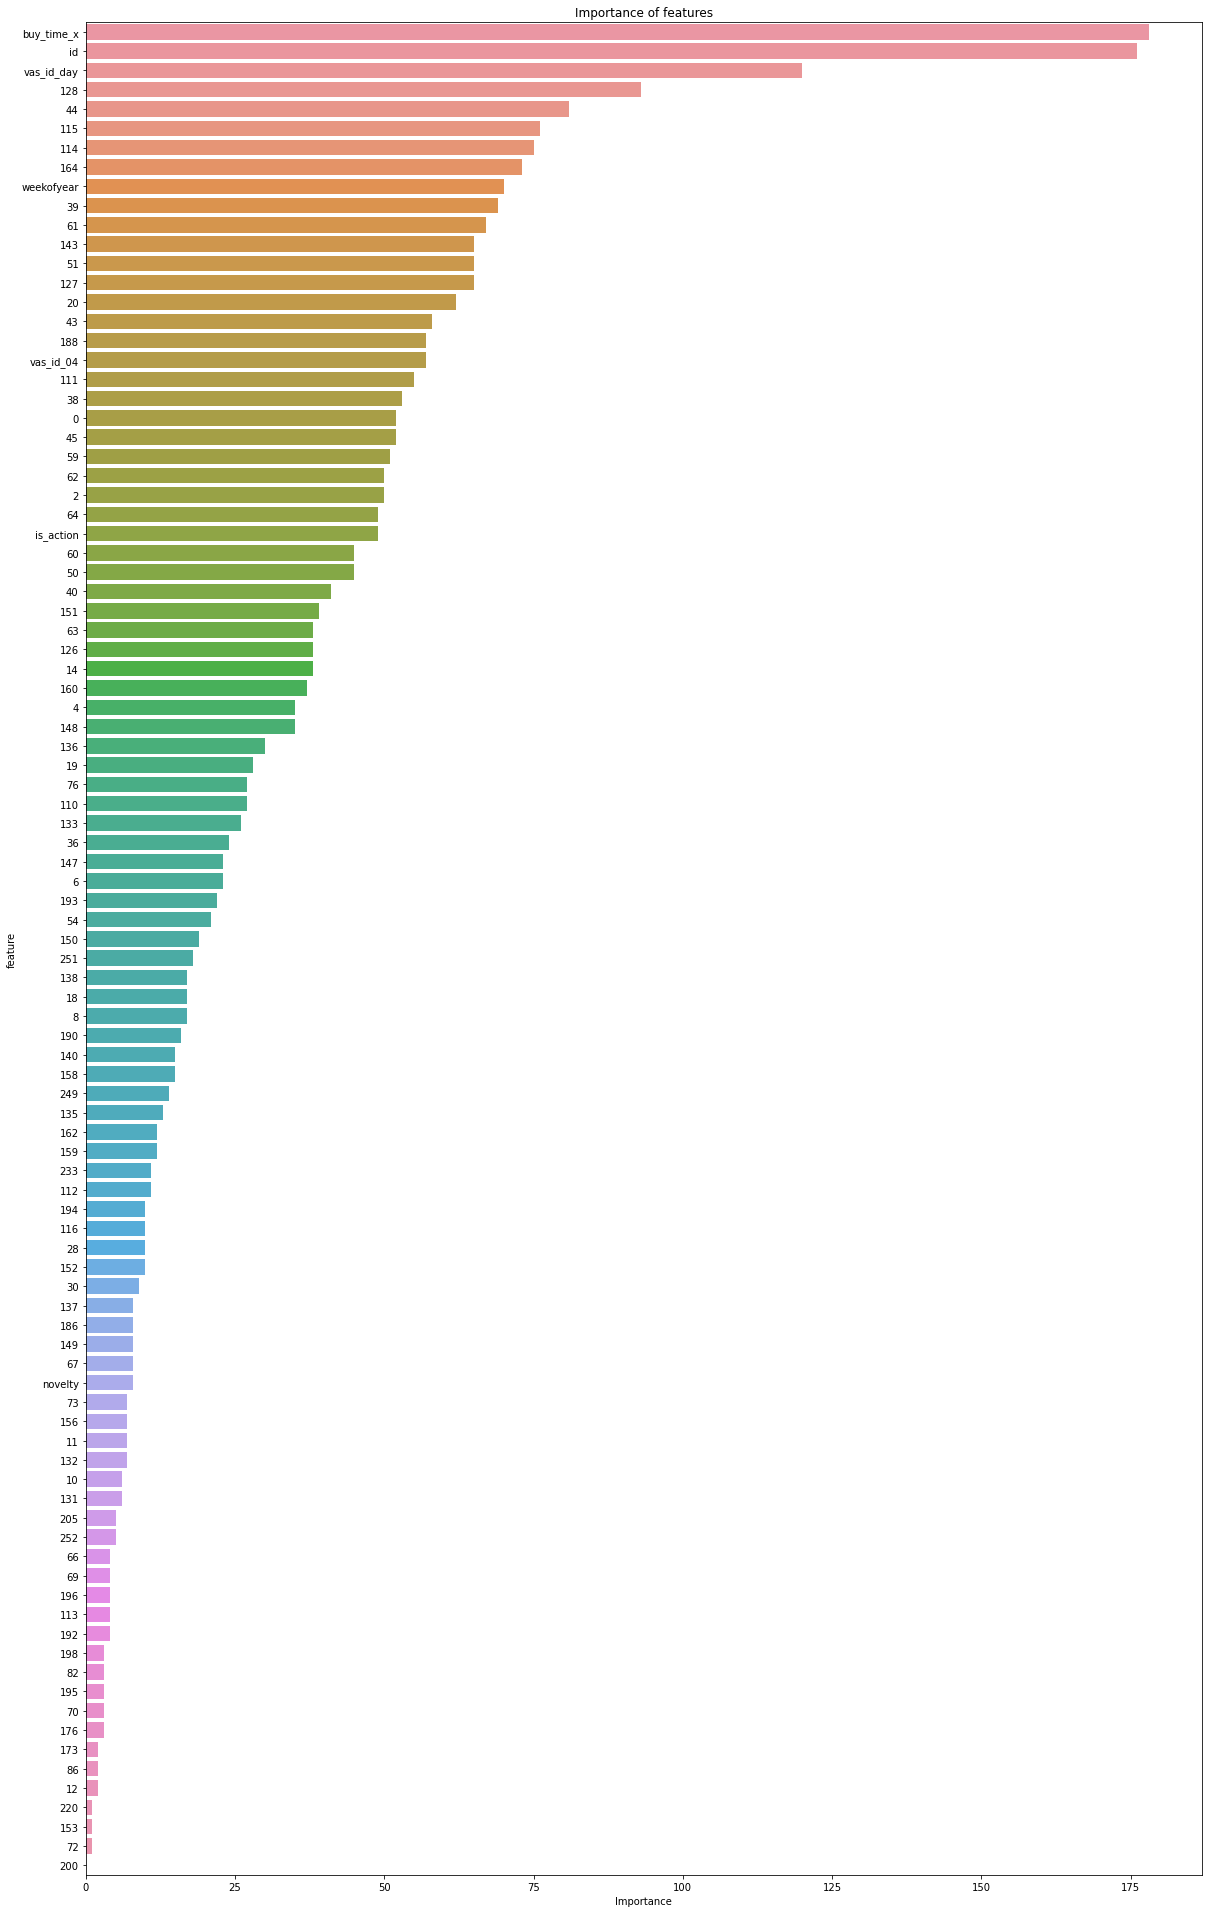

['buy_time_x', 'id', 'vas_id_day', '128', '44']

In [70]:
show_feature_importances(feature_importances['feature_name'], feature_importances['importance'], get_top = 5)

# SHAP

In [71]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [72]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model_lgbm)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


TypeError: list indices must be integers or slices, not tuple

График выше показывает вклад каждого признака в предсказание модели относительно базового значения (средний прогноз по всему тренировочному набору данных).

    Цвет точки - это значение признака
    То, насколько точка далека от вертикальной линии (серой) влево - показывает ее вклад как отрицательный
    То, насколько точка далека от вертикальной линии (серой) вправо - показывает ее положительный вклад



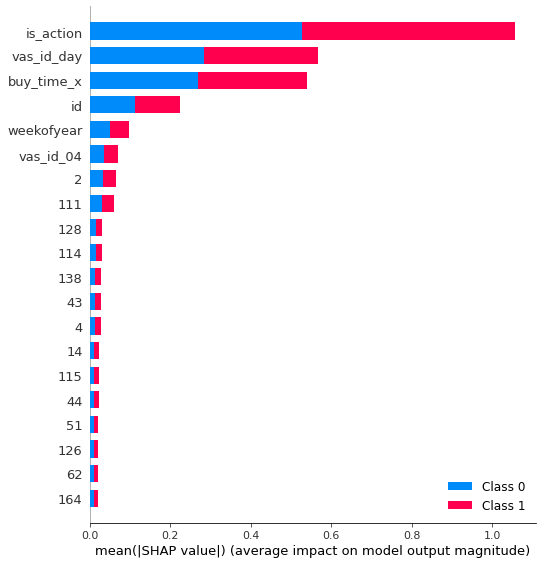

In [73]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Как его читать:

    значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
    чем толще линия на графике, тем больше таких точек наблюдения
    чем краснее точка на графике, тем выше значения признака в ней


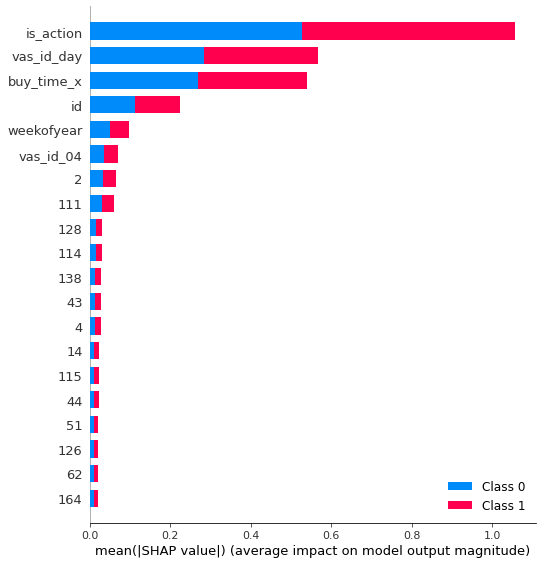

In [74]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [75]:
# Закладка
train_df4 = pd.concat([X_train, y_train], axis=1)
test_df4 = pd.concat([X_test, y_test], axis=1)
train_df4.to_csv('train_df4.csv', index=False)
test_df4.to_csv('test_df4.csv', index=False)

In [19]:
train_df4 = pd.read_csv('train_df4.csv')
test_df4 = pd.read_csv('test_df4.csv')
X_test = test_df4.drop(columns=['target'])
y_test = test_df4['target']
X_train = train_df4.drop(columns=['target'])
y_train = train_df4['target']

# Подбор гиперпараметров

In [84]:
from matplotlib import pyplot

Исследование количества деревьев


In [79]:
# get a list of models to evaluate
def get_models():
    models = dict()
    trees = [50, 100, 200, 500, 1000, 1500]
    for n in trees:
        models[str(n)] = LGBMClassifier(random_state=21, n_estimators = n)
    return models

In [80]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [81]:
# get the models to evaluate
models = get_models()

In [82]:
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>50 0.653 (0.004)
>100 0.662 (0.005)
>200 0.680 (0.007)
>500 0.730 (0.006)
>1000 0.795 (0.007)
>1500 0.837 (0.005)


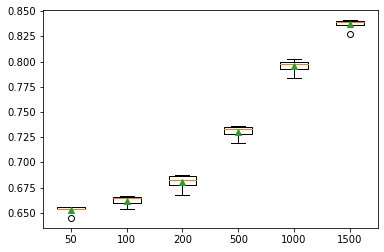

In [85]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Исследование глубины дерева


In [86]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(1,7):
        models[str(i)] = LGBMClassifier(max_depth=i, num_leaves=2**i, random_state=21)
    return models

In [87]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [88]:
# get the models to evaluate
models = get_models()

In [89]:
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>1 0.629 (0.005)
>2 0.639 (0.007)
>3 0.644 (0.005)
>4 0.649 (0.005)
>5 0.653 (0.004)
>6 0.662 (0.005)


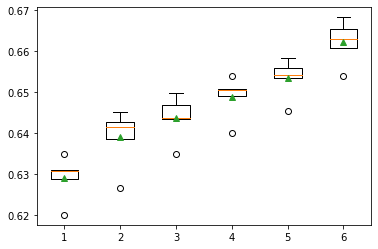

In [90]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Исследование скорости обучения


In [91]:
# get a list of models to evaluate
def get_models():
    models = dict()
    rates = [0.0001, 0.001, 0.01, 0.1, 1.0]
    for r in rates:
        key = '%.4f' % r
        models[key] = LGBMClassifier(learning_rate=r, random_state=21)
    return models

In [92]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [93]:
# get the models to evaluate
models = get_models()

In [94]:
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>0.0001 0.373 (0.001)
>0.0010 0.373 (0.001)
>0.0100 0.642 (0.005)
>0.1000 0.662 (0.005)
>1.0000 0.715 (0.002)


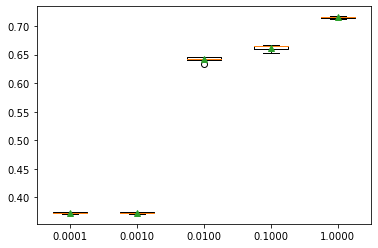

In [95]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [101]:
# get a list of models to evaluate
def get_models():
    models = dict()
    r_lambda = [0.01, 0.1, 1.0, 2, 4, 8, 16]
    for r in r_lambda:
        key = '%.4f' % r
        models[key] = LGBMClassifier(reg_lambda=r, random_state=21)
    return models

In [102]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [103]:
# get the models to evaluate
models = get_models()

In [104]:
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>0.0100 0.662 (0.003)
>0.1000 0.661 (0.004)
>1.0000 0.660 (0.006)
>2.0000 0.661 (0.004)
>4.0000 0.659 (0.004)
>8.0000 0.660 (0.003)
>16.0000 0.659 (0.003)


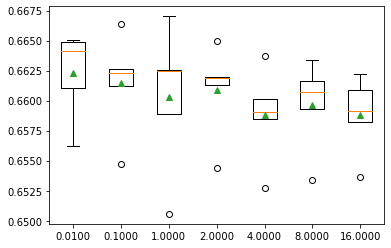

In [105]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [106]:
# get a list of models to evaluate
def get_models():
    models = dict()
    r_alpha = [0.01, 0.1, 1.0, 2, 4, 8, 16]
    for r in r_alpha:
        key = '%.4f' % r
        models[key] = LGBMClassifier(reg_alpha=r, random_state=21)
    return models

In [107]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [108]:
# get the models to evaluate
models = get_models()

In [109]:
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>0.0100 0.662 (0.005)
>0.1000 0.661 (0.004)
>1.0000 0.661 (0.004)
>2.0000 0.662 (0.006)
>4.0000 0.661 (0.005)
>8.0000 0.660 (0.003)
>16.0000 0.657 (0.004)


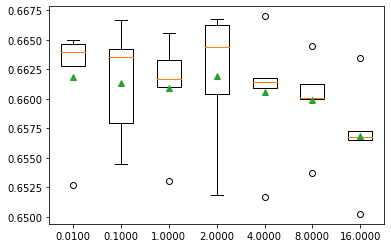

In [110]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [111]:
model_lgbm = LGBMClassifier(reg_alpha=0.01, random_state=21)

In [112]:
feature_importances = train_evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

0.0    0.59514
1.0    0.40486
Name: target, dtype: float64

0.0    0.746209
1.0    0.253791
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.71      0.95      0.81     38449
         1.0       0.85      0.42      0.56     26156

    accuracy                           0.74     64605
   macro avg       0.78      0.69      0.69     64605
weighted avg       0.76      0.74      0.71     64605

TEST

              precision    recall  f1-score   support

         0.0       0.81      0.93      0.87     25542
         1.0       0.64      0.37      0.47      8687

    accuracy                           0.79     34229
   macro avg       0.73      0.65      0.67     34229
weighted avg       0.77      0.79      0.77     34229

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     23762  1780
1.0      5456  3231


In [113]:
params = {'n_estimators':[500, 1000, 1500, 2000],
          'max_depth':[4, 5, 6, 7],
         #'learning_rate': np.linspace(0.5, .8, 10)
         }

In [114]:
cv=KFold(n_splits=5, random_state=21, shuffle=True)

In [115]:
%%time

rs = RandomizedSearchCV(model_lgbm, params, scoring='f1_macro', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

CPU times: user 60 s, sys: 718 ms, total: 1min
Wall time: 7min 27s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
                   estimator=LGBMClassifier(random_state=21, reg_alpha=0.01),
                   n_jobs=-1,
                   param_distributions={'max_depth': [4, 5, 6, 7],
                                        'n_estimators': [500, 1000, 1500,
                                                         2000]},
                   scoring='f1_macro')

Полчаса слишком много для серча. Уменьшил количество итераций. М.б. конечно в ущерб качеству.

In [116]:
rs.best_params_

{'n_estimators': 1500, 'max_depth': 6}

In [117]:
rs.best_score_

0.8114154381195616

In [118]:
best_model = LGBMClassifier(reg_alpha=0.01, random_state=21, n_estimators = 1500, max_depth = 6)

In [119]:
best_model.fit(X_train, y_train)

LGBMClassifier(max_depth=6, n_estimators=1500, random_state=21, reg_alpha=0.01)

In [120]:
evaluate_preds(best_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95     38449
         1.0       0.97      0.87      0.92     26156

    accuracy                           0.94     64605
   macro avg       0.95      0.93      0.94     64605
weighted avg       0.94      0.94      0.94     64605

TEST

              precision    recall  f1-score   support

         0.0       0.81      0.91      0.85     25542
         1.0       0.57      0.35      0.44      8687

    accuracy                           0.77     34229
   macro avg       0.69      0.63      0.65     34229
weighted avg       0.75      0.77      0.75     34229

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     23260  2282
1.0      5608  3079


переобучение

In [123]:
best_model = LGBMClassifier(reg_alpha=0.01, random_state=21, n_estimators = 1500, max_depth = 3)

In [124]:
feature_importances = train_evaluate_preds(best_model, X_train, X_test, y_train, y_test)

0.0    0.59514
1.0    0.40486
Name: target, dtype: float64

0.0    0.746209
1.0    0.253791
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.74      0.94      0.83     38449
         1.0       0.86      0.52      0.65     26156

    accuracy                           0.77     64605
   macro avg       0.80      0.73      0.74     64605
weighted avg       0.79      0.77      0.76     64605

TEST

              precision    recall  f1-score   support

         0.0       0.81      0.90      0.86     25542
         1.0       0.57      0.39      0.46      8687

    accuracy                           0.77     34229
   macro avg       0.69      0.65      0.66     34229
weighted avg       0.75      0.77      0.76     34229

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     23054  2488
1.0      5321  3366


Нет не получилось улучшить метрику.

# Снижение степени переобучения

In [126]:
params = {'reg_lambda': [0.1, 1, 2, 4],
         'learning_rate': [0.01, 0.1, 1]}

In [127]:
model = LGBMClassifier(reg_alpha=0.01, random_state=21)

In [128]:
%%time

rs = RandomizedSearchCV(model, params, scoring='f1_macro', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

CPU times: user 6.36 s, sys: 325 ms, total: 6.68 s
Wall time: 1min 3s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
                   estimator=LGBMClassifier(random_state=21, reg_alpha=0.01),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 1],
                                        'reg_lambda': [0.1, 1, 2, 4]},
                   scoring='f1_macro')

In [129]:
rs.best_score_

0.7186351600397106

In [130]:
rs.best_params_

{'reg_lambda': 4, 'learning_rate': 1}

Подобрал вручную.

In [136]:
best_model = LGBMClassifier(random_state=21, reg_alpha=0.01, learning_rate = 0.1, reg_lambda = 0.1)

In [137]:
feature_importances = train_evaluate_preds(best_model, X_train, X_test, y_train, y_test)

0.0    0.59514
1.0    0.40486
Name: target, dtype: float64

0.0    0.746209
1.0    0.253791
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.71      0.95      0.81     38449
         1.0       0.85      0.42      0.56     26156

    accuracy                           0.74     64605
   macro avg       0.78      0.69      0.69     64605
weighted avg       0.77      0.74      0.71     64605

TEST

              precision    recall  f1-score   support

         0.0       0.81      0.93      0.87     25542
         1.0       0.65      0.37      0.47      8687

    accuracy                           0.79     34229
   macro avg       0.73      0.65      0.67     34229
weighted avg       0.77      0.79      0.77     34229

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     23800  1742
1.0      5476  3211


In [138]:
best_model = LGBMClassifier(random_state=21, reg_alpha=0.01, learning_rate = 0.1, reg_lambda = 0.1)

In [139]:
kfold_cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [140]:
run_cv(best_model, kfold_cv, X_train, y_train, model_name="best_model");

best_model: f1_macro = 0.66 (+/- 0.01)


best_model: f1_macro = 0.66 (+/- 0.01)



# Штрафую нули

In [ ]:
class_weight = {0: (number of negative samples / number of positive samples), 
                1: (number of positive samples / number of negative samples)}

In [155]:
model = LGBMClassifier(random_state=21, reg_alpha=0.01, learning_rate = 0.1,
                       reg_lambda = 0.1, class_weight = {0: 1, 1: 0.9})

In [156]:
feature_importances = train_evaluate_preds(model, X_train, X_test, y_train, y_test)

0.0    0.59514
1.0    0.40486
Name: target, dtype: float64

0.0    0.746209
1.0    0.253791
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.70      0.95      0.81     38449
         1.0       0.86      0.40      0.54     26156

    accuracy                           0.73     64605
   macro avg       0.78      0.68      0.67     64605
weighted avg       0.76      0.73      0.70     64605

TEST

              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87     25542
         1.0       0.67      0.35      0.46      8687

    accuracy                           0.79     34229
   macro avg       0.74      0.65      0.67     34229
weighted avg       0.78      0.79      0.77     34229

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     24035  1507
1.0      5610  3077


In [20]:
best_model = LGBMClassifier(random_state=21, reg_alpha=0.01, learning_rate = 0.1,
                       reg_lambda = 0.1, class_weight = {0: 1, 1: 0.9})

In [21]:
feature_importances = train_evaluate_preds(best_model, X_train, X_test, y_train, y_test)

0.0    0.59514
1.0    0.40486
Name: target, dtype: float64

0.0    0.746209
1.0    0.253791
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.70      0.95      0.81     38449
         1.0       0.86      0.40      0.54     26156

    accuracy                           0.73     64605
   macro avg       0.78      0.68      0.67     64605
weighted avg       0.76      0.73      0.70     64605

TEST

              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87     25542
         1.0       0.67      0.35      0.46      8687

    accuracy                           0.79     34229
   macro avg       0.74      0.65      0.67     34229
weighted avg       0.78      0.79      0.77     34229

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     24035  1507
1.0      5610  3077


In [22]:
run_cv(best_model, kfold_cv, X_train, y_train, model_name="best_model");

best_model: f1_macro = 0.65 (+/- 0.01)


# Подбор порога

In [161]:
#наши прогнозы для тестовой выборки
preds = best_model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.88090494, 0.20497619, 0.21535569, 0.59480329, 0.36980704,
       0.25867365, 0.33221968, 0.22271121, 0.16850842, 0.29998175])

In [162]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.359355, F-Score=0.502, Precision=0.444, Recall=0.578


In [163]:
def predict_proba_to_int(y_predicted_probs, threshold):
         return (y_predicted_probs > threshold)*1

In [164]:
# Нашли метки предсказания для лучшего порога
best_predict = predict_proba_to_int(preds, thresholds[ix])

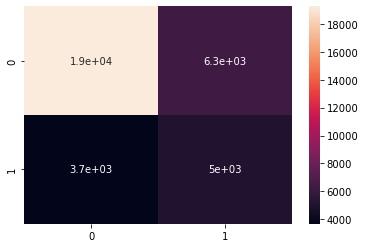

In [165]:
sns.heatmap(confusion_matrix(y_test, best_predict), annot=True)
plt.show()

Модернизирую функцию evaluate_preds для получения скоров с учетом лучшего вероятностного порога.

In [166]:
def evaluate_preds_with_threshold(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_poba = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test,\
                                                           y_test_poba)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    best_predict = predict_proba_to_int(y_test_poba, thresholds[ix])
    

    get_classification_report(y_train, y_train_pred, y_test, best_predict)
    print('Best Threshold=%f' % (thresholds[ix]))
    
    return best_predict

In [167]:
evaluate_preds(best_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       0.70      0.95      0.81     38449
         1.0       0.86      0.40      0.54     26156

    accuracy                           0.73     64605
   macro avg       0.78      0.68      0.67     64605
weighted avg       0.76      0.73      0.70     64605

TEST

              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87     25542
         1.0       0.67      0.35      0.46      8687

    accuracy                           0.79     34229
   macro avg       0.74      0.65      0.67     34229
weighted avg       0.78      0.79      0.77     34229

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     24035  1507
1.0      5610  3077


In [168]:
best_predict = evaluate_preds_with_threshold(best_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       0.70      0.95      0.81     38449
         1.0       0.86      0.40      0.54     26156

    accuracy                           0.73     64605
   macro avg       0.78      0.68      0.67     64605
weighted avg       0.76      0.73      0.70     64605

TEST

              precision    recall  f1-score   support

         0.0       0.84      0.75      0.79     25542
         1.0       0.44      0.58      0.50      8687

    accuracy                           0.71     34229
   macro avg       0.64      0.67      0.65     34229
weighted avg       0.74      0.71      0.72     34229

CONFUSION MATRIX

col_0       0     1
target             
0.0     19265  6277
1.0      3670  5017
Best Threshold=0.359355


Метрика ухухдшилась.

Написал функцию для тонкой настройки трешхолда

In [169]:
def predict_proba_compare(model, X_test, X_train, y_test, y_train, cut_off):
    # функция изменения линии отсечки при расчете таргета
    pred_proba_test = model.predict_proba(X_test)
    y_test_proba=np.where(pred_proba_test[:, 1] > cut_off, 1, 0)
    pred_proba_train = model.predict_proba(X_train)
    y_train_proba=np.where(pred_proba_train[:, 1] > cut_off, 1, 0)
    print('TRAIN\n\n' + classification_report(y_train, y_train_proba))
    print('TEST\n\n' + classification_report(y_test, y_test_proba))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test, y_test_proba))
    
    return y_train_proba, y_test_proba

In [170]:
predict_proba_compare(best_model, X_test, X_train, y_test, y_train, 0.359355)

TRAIN

              precision    recall  f1-score   support

         0.0       0.77      0.79      0.78     38449
         1.0       0.68      0.66      0.67     26156

    accuracy                           0.74     64605
   macro avg       0.73      0.73      0.73     64605
weighted avg       0.74      0.74      0.74     64605

TEST

              precision    recall  f1-score   support

         0.0       0.84      0.75      0.79     25542
         1.0       0.44      0.58      0.50      8687

    accuracy                           0.71     34229
   macro avg       0.64      0.67      0.65     34229
weighted avg       0.74      0.71      0.72     34229

CONFUSION MATRIX

col_0       0     1
target             
0.0     19265  6277
1.0      3669  5018


(array([1, 1, 0, ..., 1, 1, 0]), array([1, 0, 0, ..., 0, 0, 1]))

In [176]:
predict_proba_compare(best_model, X_test, X_train, y_test, y_train, 0.55)

TRAIN

              precision    recall  f1-score   support

         0.0       0.69      0.96      0.80     38449
         1.0       0.87      0.36      0.51     26156

    accuracy                           0.72     64605
   macro avg       0.78      0.66      0.66     64605
weighted avg       0.76      0.72      0.68     64605

TEST

              precision    recall  f1-score   support

         0.0       0.81      0.95      0.87     25542
         1.0       0.70      0.34      0.46      8687

    accuracy                           0.80     34229
   macro avg       0.76      0.64      0.67     34229
weighted avg       0.78      0.80      0.77     34229

CONFUSION MATRIX

col_0       0     1
target             
0.0     24306  1236
1.0      5755  2932


(array([0, 0, 0, ..., 1, 1, 0]), array([1, 0, 0, ..., 0, 0, 0]))

In [177]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [178]:
y_test_poba = best_model.predict_proba(X_test)[:, 1]

Confusion matrix, without normalization
[[19265  6277]
 [ 3669  5018]]


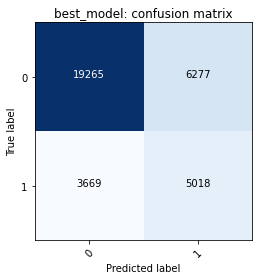

In [180]:
cm = confusion_matrix(y_test, y_test_poba > 0.359355)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");

Confusion matrix, without normalization
[[24035  1507]
 [ 5610  3077]]


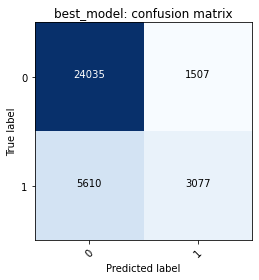

In [181]:
cm = confusion_matrix(y_test, y_test_poba > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");

С трешхолдом нет смысла возиться.

# Создаю пайплайн

На балансированных данных!

In [17]:
columns_4 = ['buy_time_x', '0', '2', '4', '6', '8', '10', '11', '12', '14', '18',
      '19', '20', '28', '30', '36', '38', '39', '40', '43', '44', '45', '50',
      '51', '54', '59', '60', '61', '62', '63', '64', '66', '67', '69', '70',
      '72', '73', '76', '82', '86', '110', '111', '112', '113', '114', '115', '116',
      '126', '127', '128', '131', '132', '133', '135', '136', '137', '138',
      '140', '143', '147', '148', '149', '150', '151', '152', '153', '156', '158',
      '159', '160', '162', '164', '173', '176', '186', '188', '190', '192', '193',
      '194', '195', '196', '198', '200', '205', '220', '233', '249', '251', '252',
      'vas_id_04', 'weekofyear', 'novelty', 'vas_id_day', 'is_action', 'id']

In [18]:
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [19]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [20]:
Selected_Columns = Pipeline([
                ('selector', ColumnSelector(columns_4))
            ])

In [21]:
pipeline = Pipeline([
    ('Selected_Columns', Selected_Columns),
    ('classifier', LGBMClassifier(random_state=21, reg_alpha=0.01, learning_rate = 0.1,
                       reg_lambda = 0.1, class_weight = {0: 1, 1: 0.9}))
])

In [7]:
import pickle

In [23]:
with open('model_4.pkl', 'wb') as model:
    pickle.dump(pipeline, model)

In [24]:
with open('model_4.pkl', 'rb') as model:
    x = pickle.load(model)

In [191]:
x.fit(X_train_balanced, y_train_balanced)

Pipeline(steps=[('Selected_Columns',
                 Pipeline(steps=[('selector',
                                  ColumnSelector(key=['buy_time_x', '0', '2',
                                                      '4', '6', '8', '10', '11',
                                                      '12', '14', '18', '19',
                                                      '20', '28', '30', '36',
                                                      '38', '39', '40', '43',
                                                      '44', '45', '50', '51',
                                                      '54', '59', '60', '61',
                                                      '62', '63', ...]))])),
                ('classifier',
                 LGBMClassifier(class_weight={0: 1, 1: 0.9}, random_state=21,
                                reg_alpha=0.01, reg_lambda=0.1))])

Confusion matrix, without normalization
[[24035  1507]
 [ 5610  3077]]


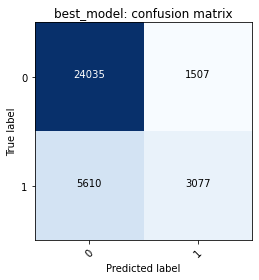

In [193]:
y_test_proba = x.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_test_proba > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");

In [5]:
best_model = LGBMClassifier(random_state=21, reg_alpha=0.01, learning_rate = 0.1,
                       reg_lambda = 0.1, class_weight = {0: 1, 1: 0.9})

In [8]:
with open('model4.pkl', 'wb') as model:
    pickle.dump(best_model, model)

In [ ]:
with open('model4.pkl', 'rb') as model:
    loaded_model = pickle.load(model)

In [ ]:
y_test_proba = loaded_model.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_test_proba > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");